In [1]:
import os,gc,sys
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy
from glob import glob

import pickle
# import feather
%matplotlib inline

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from matplotlib.colors import ListedColormap

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from itertools import cycle

plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted",
        color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

In [4]:
#表示するrow,columns調整
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
#分析・集計に使うモジュールとライブラリ
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

#各種機械学習モデル
#LogisticRegression
from sklearn.linear_model import LogisticRegression
#Linear Support Vector Machine
from sklearn.svm import LinearSVC
#Support Vector Machine
from sklearn.svm import SVC
#決定木
from sklearn.tree import DecisionTreeClassifier
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
#k近傍方（k-neighbor）
from sklearn.neighbors import KNeighborsClassifier
#Logistic-regression
from sklearn.linear_model import LogisticRegression

#学習方法（GridSearchCV）
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#scikiti-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score

#スコアリング（f値）
from sklearn.metrics import f1_score

#lightgbm
import lightgbm as lgb
# import pandas_profiling as pdp


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def make_fulldata(save=True):
    
    root = '../input/'
    
    sample_submission_df = pd.read_csv(root + 'sample_submission.csv')
    sell_prices_df = pd.read_csv(root + 'sell_prices.csv')
    calendar_df = pd.read_csv(root + 'calendar.csv')
    sales_train_validation_df = pd.read_csv(root + 'sales_train_validation.csv')
    
    if save:
        sample_submission_df.to_pickle(root + f'pickle/sample_submission_df.pkl')
        sell_prices_df.to_pickle(root + f'pickle/sell_prices_df.pkl')
        calendar_df.to_pickle(root + f'pickle/calendar_df.pkl')
        sales_train_validation_df.to_pickle(root + f'pickle/sales_train_validation_df.pkl')

    return sample_submission_df, sell_prices_df, calendar_df, sales_train_validation_df

In [6]:
def read_all_pickle(root):
    sample_submission_df = pd.read_pickle(root + 'sample_submission_df.pkl')
    sell_prices_df = pd.read_pickle(root + 'sell_prices_df.pkl')
    calendar_df = pd.read_pickle(root + 'calendar_df.pkl')
    sales_train_validation_df = pd.read_pickle(root + 'sales_train_validation_df.pkl')
    return sample_submission_df, sell_prices_df, calendar_df, sales_train_validation_df

In [8]:
def get_info(target_df, topN=10, zero=False, u_val=False):
    max_row = len(target_df)
    print(f'Shape: {target_df.shape}')
    
    df = target_df.dtypes.to_frame()
    df.columns = ['DataType']
    df['Nulls'] = target_df.isnull().sum()
    df['Null%'] = df['Nulls'] / max_row * 100
    df['Uniques'] = target_df.nunique()
    df['Unique%'] = df['Uniques'] / max_row * 100
    
    if zero:
        df['Zeros'] = (train_genba == 0).sum()
        df['Zero%'] = df['Zeros'] / max_row
    
    # stats
    df['Min']   = target_df.min(numeric_only=True)
    df['Mean']  = target_df.mean(numeric_only=True)
    df['Max']   = target_df.max(numeric_only=True)
    df['Std']   = target_df.std(numeric_only=True)
    
    # top 10 values
    df[f'top{topN} val'] = 0
    df[f'top{topN} cnt'] = 0
    df[f'top{topN} raito'] = 0
    for c in df.index:
        vc = target_df[c].value_counts().head(topN)
        val = list(vc.index)
        cnt = list(vc.values)
        raito = list((vc.values / max_row).round(2))
        df.loc[c, f'top{topN} val'] = str(val)
        df.loc[c, f'top{topN} cnt'] = str(cnt)
        df.loc[c, f'top{topN} raito'] = str(raito)
        
    if u_val:
        df['u_val'] = [target_df[col].unique() for col in cols]
        
    return df

In [8]:
root = '../../input/pickle/'
sample_submission_df, sell_prices_df, calendar_df, sales_train_validation_df = read_all_pickle(root)

In [9]:
display(sample_submission_df.head(100))
display(sample_submission_df.shape)

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  \
0   HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
1   HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
2   HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
3   HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
4   HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
5   HOBBIES_1_006_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
6   HOBBIES_1_007_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
7   HOBBIES_1_008_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
8   HOBBIES_1_009_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
9   HOBBIES_1_010_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
10  HOBBIES_1_011_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
11  HOBBIES_1_012_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
12  HOBBIES_1_013_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
13  HOBBIES_1_014_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
14  HOBBIES_1_015_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
15  HOBBIES_1_016_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
16  HOBBIES_1_017_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
17  HOBBIES_1_018_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
18  HOBBIES_1_019_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
19  HOBBIES_1_020_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
20  HOBBIES_1_021_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
21  HOBBIES_1_022_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
22  HOBBIES_1_023_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
23  HOBBIES_1_024_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
24  HOBBIES_1_025_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
25  HOBBIES_1_026_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
26  HOBBIES_1_027_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
27  HOBBIES_1_028_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
28  HOBBIES_1_029_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
29  HOBBIES_1_030_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
30  HOBBIES_1_031_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
31  HOBBIES_1_032_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
32  HOBBIES_1_033_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
33  HOBBIES_1_034_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
34  HOBBIES_1_035_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
35  HOBBIES_1_036_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
36  HOBBIES_1_037_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
37  HOBBIES_1_038_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
38  HOBBIES_1_039_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
39  HOBBIES_1_040_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
40  HOBBIES_1_041_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
41  HOBBIES_1_042_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
42  HOBBIES_1_043_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
43  HOBBIES_1_044_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
44  HOBBIES_1_045_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
45  HOBBIES_1_046_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
46  HOBBIES_1_047_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
47  HOBBIES_1_048_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
48  HOBBIES_1_049_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
49  HOBBIES_1_050_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
50  HOBBIES_1_051_CA_1_validation   0   0   0   0   0

(60980, 29)

In [10]:
display(sell_prices_df.head(100))
display(sell_prices_df.shape)

store_id        item_id  wm_yr_wk  sell_price
0      CA_1  HOBBIES_1_001     11325        9.58
1      CA_1  HOBBIES_1_001     11326        9.58
2      CA_1  HOBBIES_1_001     11327        8.26
3      CA_1  HOBBIES_1_001     11328        8.26
4      CA_1  HOBBIES_1_001     11329        8.26
5      CA_1  HOBBIES_1_001     11330        8.26
6      CA_1  HOBBIES_1_001     11331        8.26
7      CA_1  HOBBIES_1_001     11332        8.26
8      CA_1  HOBBIES_1_001     11333        8.26
9      CA_1  HOBBIES_1_001     11334        8.26
10     CA_1  HOBBIES_1_001     11335        8.26
11     CA_1  HOBBIES_1_001     11336        8.26
12     CA_1  HOBBIES_1_001     11337        8.26
13     CA_1  HOBBIES_1_001     11338        8.26
14     CA_1  HOBBIES_1_001     11339        8.26
15     CA_1  HOBBIES_1_001     11340        8.26
16     CA_1  HOBBIES_1_001     11341        8.26
17     CA_1  HOBBIES_1_001     11342        8.26
18     CA_1  HOBBIES_1_001     11343        8.26
19     CA_1  HOBBIES_1_001     11344        8.26
20     CA_1  HOBBIES_1_001     11345        8.26
21     CA_1  HOBBIES_1_001     11346        8.26
22     CA_1  HOBBIES_1_001     11347        8.26
23     CA_1  HOBBIES_1_001     11348        8.26
24     CA_1  HOBBIES_1_001     11349        8.26
25     CA_1  HOBBIES_1_001     11350        8.26
26     CA_1  HOBBIES_1_001     11351        8.26
27     CA_1  HOBBIES_1_001     11352        8.26
28     CA_1  HOBBIES_1_001     11353        8.26
29     CA_1  HOBBIES_1_001     11401        8.26
30     CA_1  HOBBIES_1_001     11402        8.26
31     CA_1  HOBBIES_1_001     11403        8.26
32     CA_1  HOBBIES_1_001     11404        8.26
33     CA_1  HOBBIES_1_001     11405        8.26
34     CA_1  HOBBIES_1_001     11406        8.26
35     CA_1  HOBBIES_1_001     11407        8.26
36     CA_1  HOBBIES_1_001     11408        8.26
37     CA_1  HOBBIES_1_001     11409        8.26
38     CA_1  HOBBIES_1_001     11410        8.26
39     CA_1  HOBBIES_1_001     11411        8.26
40     CA_1  HOBBIES_1_001     11412        8.26
41     CA_1  HOBBIES_1_001     11413        8.26
42     CA_1  HOBBIES_1_001     11414        8.26
43     CA_1  HOBBIES_1_001     11415        8.26
44     CA_1  HOBBIES_1_001     11416        8.26
45     CA_1  HOBBIES_1_001     11417        8.26
46     CA_1  HOBBIES_1_001     11418        8.26
47     CA_1  HOBBIES_1_001     11419        8.26
48     CA_1  HOBBIES_1_001     11420        8.26
49     CA_1  HOBBIES_1_001     11421        8.26
50     CA_1  HOBBIES_1_001     11422        8.26
51     CA_1  HOBBIES_1_001     11423        8.26
52     CA_1  HOBBIES_1_001     11424        8.26
53     CA_1  HOBBIES_1_001     11425        8.26
54     CA_1  HOBBIES_1_001     11426        8.26
55     CA_1  HOBBIES_1_001     11427        8.26
56     CA_1  HOBBIES_1_001     11428        8.26
57     CA_1  HOBBIES_1_001     11429        8.26
58     CA_1  HOBBIES_1_001     11430        8.26
59     CA_1  HOBBIES_1_001     11431        8.26
60     CA_1  HOBBIES_1_001     11432        8.26
61     CA_1  HOBBIES_1_001     11433        8.26
62     CA_1  HOBBIES_1_001     11434        8.26
63     CA_1  HOBBIES_1_001     11435        8.26
64     CA_1  HOBBIES_1_001     11436        8.26
65     CA_1  HOBBIES_1_001     11437        8.26
66     CA_1  HOBBIES_1_001     11438        8.26
67     CA_1  HOBBIES_1_001     11439        8.26
68     CA_1  HOBBIES_1_001     11440        8.26
69     CA_1  HOBBIES_1_001     11441        8.26
70     CA_1  HOBBIES_1_001     11442        8.26
71     CA_1  HOBBIES_1_001     11443        8.26
72     CA_1  HOBBIES_1_001     11444        8.26
73     CA_1  HOBBIES_1_001     11445        8.26
74     CA_1  HOBBIES_1_001     11446        8.26
75     CA_1  HOBBIES_1_001     11447        8.26
76     CA_1  HOBBIES_1_001     11448        8.26
77     CA_1  HOBBIES_1_001     11449        8.26
78     CA_1  HOBBIES_1_001     11450        8.26
79     CA_1  HOBBIES_1_001     11451        8.26
80     CA_1  HOBBIES_1_001     114

(6841121, 4)

In [11]:
display(calendar_df.head(100))
display(calendar_df.shape)

date  wm_yr_wk    weekday  wday  month  year      d    event_name_1  \
0   2011-01-29     11101   Saturday     1      1  2011    d_1             NaN   
1   2011-01-30     11101     Sunday     2      1  2011    d_2             NaN   
2   2011-01-31     11101     Monday     3      1  2011    d_3             NaN   
3   2011-02-01     11101    Tuesday     4      2  2011    d_4             NaN   
4   2011-02-02     11101  Wednesday     5      2  2011    d_5             NaN   
5   2011-02-03     11101   Thursday     6      2  2011    d_6             NaN   
6   2011-02-04     11101     Friday     7      2  2011    d_7             NaN   
7   2011-02-05     11102   Saturday     1      2  2011    d_8             NaN   
8   2011-02-06     11102     Sunday     2      2  2011    d_9       SuperBowl   
9   2011-02-07     11102     Monday     3      2  2011   d_10             NaN   
10  2011-02-08     11102    Tuesday     4      2  2011   d_11             NaN   
11  2011-02-09     11102  Wednesday     5      2  2011   d_12             NaN   
12  2011-02-10     11102   Thursday     6      2  2011   d_13             NaN   
13  2011-02-11     11102     Friday     7      2  2011   d_14             NaN   
14  2011-02-12     11103   Saturday     1      2  2011   d_15             NaN   
15  2011-02-13     11103     Sunday     2      2  2011   d_16             NaN   
16  2011-02-14     11103     Monday     3      2  2011   d_17   ValentinesDay   
17  2011-02-15     11103    Tuesday     4      2  2011   d_18             NaN   
18  2011-02-16     11103  Wednesday     5      2  2011   d_19             NaN   
19  2011-02-17     11103   Thursday     6      2  2011   d_20             NaN   
20  2011-02-18     11103     Friday     7      2  2011   d_21             NaN   
21  2011-02-19     11104   Saturday     1      2  2011   d_22             NaN   
22  2011-02-20     11104     Sunday     2      2  2011   d_23             NaN   
23  2011-02-21     11104     Monday     3      2  2011   d_24   PresidentsDay   
24  2011-02-22     11104    Tuesday     4      2  2011   d_25             NaN   
25  2011-02-23     11104  Wednesday     5      2  2011   d_26             NaN   
26  2011-02-24     11104   Thursday     6      2  2011   d_27             NaN   
27  2011-02-25     11104     Friday     7      2  2011   d_28             NaN   
28  2011-02-26     11105   Saturday     1      2  2011   d_29             NaN   
29  2011-02-27     11105     Sunday     2      2  2011   d_30             NaN   
30  2011-02-28     11105     Monday     3      2  2011   d_31             NaN   
31  2011-03-01     11105    Tuesday     4      3  2011   d_32             NaN   
32  2011-03-02     11105  Wednesday     5      3  2011   d_33             NaN   
33  2011-03-03     11105   Thursday     6      3  2011   d_34             NaN   
34  2011-03-04     11105     Friday     7      3  2011   d_35             NaN   
35  2011-03-05     11106   Saturday     1      3  2011   d_36             NaN   
36  2011-03-06     11106     Sunday     2      3  2011   d_37             NaN   
37  2011-03-07     11106     Monday     3      3  2011   d_38             NaN   
38  2011-03-08     11106    Tuesday     4      3  2011   d_39             NaN   
39  2011-03-09     11106  Wednesday     5      3  2011   d_40       LentStart   
40  2011-03-10     11106   Thursday     6      3  2011   d_41             NaN   
41  2011-03-11     11106     Friday     7      3  2011   d_42             NaN   
42  2011-03-12     11107   Saturday     1      3  2011   d_43             NaN   
43  2011-03-13     11107     Sunday     2      3  2011   d_44             NaN   
44  2011-03-14     11107     Monday     3      3  2011   d_45             NaN   
45  2011-03-15     11107    Tuesday     4      3  2011   d_46             NaN   
46  2011-03-16     11107  Wednesday     5      3  2011   d_47       LentWeek2   
47  2011-03-17     11107   Thursday     6      3  2011   d_48   StPatricksDay   
48  2011-03-18     11107     Friday     7

(1969, 14)

In [12]:
display(sales_train_validation_df.head(100))
display(sales_train_validation_df.shape)

id        item_id    dept_id   cat_id store_id  \
0   HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1   HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2   HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3   HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4   HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5   HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6   HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7   HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8   HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9   HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   
10  HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES     CA_1   
11  HOBBIES_1_012_CA_1_validation  HOBBIES_1_012  HOBBIES_1  HOBBIES     CA_1   
12  HOBBIES_1_013_CA_1_validation  HOBBIES_1_013  HOBBIES_1  HOBBIES     CA_1   
13  HOBBIES_1_014_CA_1_validation  HOBBIES_1_014  HOBBIES_1  HOBBIES     CA_1   
14  HOBBIES_1_015_CA_1_validation  HOBBIES_1_015  HOBBIES_1  HOBBIES     CA_1   
15  HOBBIES_1_016_CA_1_validation  HOBBIES_1_016  HOBBIES_1  HOBBIES     CA_1   
16  HOBBIES_1_017_CA_1_validation  HOBBIES_1_017  HOBBIES_1  HOBBIES     CA_1   
17  HOBBIES_1_018_CA_1_validation  HOBBIES_1_018  HOBBIES_1  HOBBIES     CA_1   
18  HOBBIES_1_019_CA_1_validation  HOBBIES_1_019  HOBBIES_1  HOBBIES     CA_1   
19  HOBBIES_1_020_CA_1_validation  HOBBIES_1_020  HOBBIES_1  HOBBIES     CA_1   
20  HOBBIES_1_021_CA_1_validation  HOBBIES_1_021  HOBBIES_1  HOBBIES     CA_1   
21  HOBBIES_1_022_CA_1_validation  HOBBIES_1_022  HOBBIES_1  HOBBIES     CA_1   
22  HOBBIES_1_023_CA_1_validation  HOBBIES_1_023  HOBBIES_1  HOBBIES     CA_1   
23  HOBBIES_1_024_CA_1_validation  HOBBIES_1_024  HOBBIES_1  HOBBIES     CA_1   
24  HOBBIES_1_025_CA_1_validation  HOBBIES_1_025  HOBBIES_1  HOBBIES     CA_1   
25  HOBBIES_1_026_CA_1_validation  HOBBIES_1_026  HOBBIES_1  HOBBIES     CA_1   
26  HOBBIES_1_027_CA_1_validation  HOBBIES_1_027  HOBBIES_1  HOBBIES     CA_1   
27  HOBBIES_1_028_CA_1_validation  HOBBIES_1_028  HOBBIES_1  HOBBIES     CA_1   
28  HOBBIES_1_029_CA_1_validation  HOBBIES_1_029  HOBBIES_1  HOBBIES     CA_1   
29  HOBBIES_1_030_CA_1_validation  HOBBIES_1_030  HOBBIES_1  HOBBIES     CA_1   
30  HOBBIES_1_031_CA_1_validation  HOBBIES_1_031  HOBBIES_1  HOBBIES     CA_1   
31  HOBBIES_1_032_CA_1_validation  HOBBIES_1_032  HOBBIES_1  HOBBIES     CA_1   
32  HOBBIES_1_033_CA_1_validation  HOBBIES_1_033  HOBBIES_1  HOBBIES     CA_1   
33  HOBBIES_1_034_CA_1_validation  HOBBIES_1_034  HOBBIES_1  HOBBIES     CA_1   
34  HOBBIES_1_035_CA_1_validation  HOBBIES_1_035  HOBBIES_1  HOBBIES     CA_1   
35  HOBBIES_1_036_CA_1_validation  HOBBIES_1_036  HOBBIES_1  HOBBIES     CA_1   
36  HOBBIES_1_037_CA_1_validation  HOBBIES_1_037  HOBBIES_1  HOBBIES     CA_1   
37  HOBBIES_1_038_CA_1_validation  HOBBIES_1_038  HOBBIES_1  HOBBIES     CA_1   
38  HOBBIES_1_039_CA_1_validation  HOBBIES_1_039  HOBBIES_1  HOBBIES     CA_1   
39  HOBBIES_1_040_CA_1_validation  HOBBIES_1_040  HOBBIES_1  HOBBIES     CA_1   
40  HOBBIES_1_041_CA_1_validation  HOBBIES_1_041  HOBBIES_1  HOBBIES     CA_1   
41  HOBBIES_1_042_CA_1_validation  HOBBIES_1_042  HOBBIES_1  HOBBIES     CA_1   
42  HOBBIES_1_043_CA_1_validation  HOBBIES_1_043  HOBBIES_1  HOBBIES     CA_1   
43  HOBBIES_1_044_CA_1_validation  HOBBIES_1_044  HOBBIES_1  HOBBIES     CA_1   
44  HOBBIES_1_045_CA_1_validation  HOBBIES_1_045  HOBBIES_1  HOBBIES     CA_1   
45  HOBBIES_1_046_CA_1_validation  HOBBIES_1_046  HOBBIES_1  HOBBIES     CA_1   
46  HOBBIES_1_047_CA_1_validation  HOBBIES_1_047  HOBBIES_1  HOBBIES     CA_1   
47  HOBBIES_1_048_CA_1_validation  HOBBIES_1_048  HOBBIES_1  HOBBIES     CA_1   
48  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  H

(30490, 1919)

3/15
# Rob's kernel

sales_train_validation_df：1~1913日までのアイテムの「アイテムの部門」「カテゴリ」「州」「ストアID」が与えられている

sample_submission_df：Submitの内容は1914~1941日までの28日間の売り上げ予測の検証するデータ

### 置き換え

In [16]:
ss = sample_submission_df.copy()
stv = sales_train_validation_df.copy()
sp = sell_prices_df.copy()

### Visualization

適当なアイテムについて可視化してみる

FOODS_3_090_CA_3_validation

In [17]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


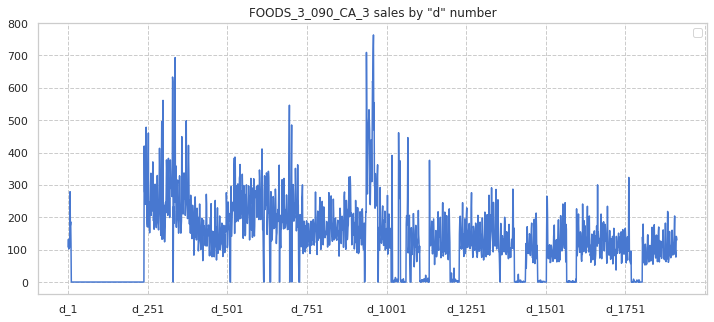

In [18]:
day_cols = [c for c in stv.columns if 'd_' in c]
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols].T.plot(figsize=(12, 5), 
                                    title='FOODS_3_090_CA_3 sales by "d" number')
plt.legend('')
plt.show()

itemがないところは（d_1~d_251までとか）売り上げがFlatになっている

In [19]:
sp = sell_prices_df.copy()

In [20]:
sp.describe()

wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04           NaN
std    1.486100e+02  0.000000e+00
min    1.110100e+04  1.000214e-02
25%    1.124700e+04  2.179688e+00
50%    1.141100e+04  3.470703e+00
75%    1.151700e+04  5.839844e+00
max    1.162100e+04  1.073125e+02

### Marging calender

Calenderテーブルのロブの気になったカラムだけ抽出。itemsテーブルとマージ

In [21]:
cal = calendar_df.copy()

In [22]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
             'event_type_1','event_type_2', 'snap_CA']].head()

d        date event_name_1 event_name_2 event_type_1 event_type_2  \
0  d_1  2011-01-29          NaN          NaN          NaN          NaN   
1  d_2  2011-01-30          NaN          NaN          NaN          NaN   
2  d_3  2011-01-31          NaN          NaN          NaN          NaN   
3  d_4  2011-02-01          NaN          NaN          NaN          NaN   
4  d_5  2011-02-02          NaN          NaN          NaN          NaN   

   snap_CA  
0        0  
1        0  
2        0  
3        1  
4        1

In [23]:
cal.event_name_1.unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

### 州ごとの売り上げを観察していく

1.カテゴリーでテーブル分ける

2.売れてるカテゴリーの順番に並べてみた

3.上位抜出し

In [24]:
stv_FOODS = stv[stv['id'].str.contains('FOODS')]
stv_HOBBIES = stv[stv['id'].str.contains('HOBBIES')]
stv_HOUSEHOLD = stv[stv['id'].str.contains('HOUSEHOLD')]

In [25]:
sum_list_FOODS = stv_FOODS[day_cols].sum(axis=1).sort_values(ascending=False).index[:1]
sum_list_HOBBIES = stv_HOBBIES[day_cols].sum(axis=1).sort_values(ascending=False).index[:1]
sum_list_HOUSEHOLD = stv_HOUSEHOLD[day_cols].sum(axis=1).sort_values(ascending=False).index[:1]
display(stv.iloc[sum_list_FOODS])
display(stv.iloc[sum_list_HOBBIES])
display(stv.iloc[sum_list_HOUSEHOLD])

id      item_id  dept_id cat_id store_id  \
8412  FOODS_3_090_CA_3_validation  FOODS_3_090  FOODS_3  FOODS     CA_3   

     state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
8412       CA  108  132  102  120  106  123  279  175  186   120     0     0   

      d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_97  d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  d_106  \
8412     0     0     0      0      0      0      0      0      0      0   

      d_107  d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  d_116  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_117  d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  d_126  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_127  d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  d_136  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_137  d_138  d_139  d_140  d_141  d_142  d_143  d_144  d_145  d_146  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_147  d_148  d_149  d_150  d_151  d_152  d_153  d_154  d_155  d_156  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_157  d_158  d_159  d_160  d_161  d_162  d_163  d_164  d_165  d_166  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_167  d_168  d_169  d_170  d_171  d_172  d_173  d_174  d_175  d_176  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_177  d_178  d_179  d_180  d_181  d_182  d_183  d_184  d_185  d_186  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_187  d_188  d_189  d_190  d_191  d_192  d_193  d_194  d_195  d_196  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_197  d_198  d_199  d_200  d_201  d_202  d_203  d_204  d_205  d_206  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_207  d_208  d_209  d_210  d_211  d_212  d_213  d_214  d_215  d_216  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_217  d_218  d_219  d_220  d_221  d_222  d_223  d_224  d_225  d_226  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_227  d_228  d_229  d_230  d_231  d_232  d_233  d_234  d_235  d_236  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_237  d_238  d_239  d_240  d_241  d_242  d_243  d_244  d_245  d_246  \
8412      0      0      0    420    280    273    254    240    336    478   

      d_247  d_248  d_249  d_250  d_251  d_252  d_253  d_254  d_255  d_256  \
8412    359    234    180    170    249    254    460    170    229    225   

      d_257  d_258  d_259  d_260  d_261  d_262  d_263  d_264  d_265  d_266  \
8412    

id        item_id    dept_id   cat_id  \
6324  HOBBIES_1_234_CA_3_validation  HOBBIES_1_234  HOBBIES_1  HOBBIES   

     store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
6324     CA_3       CA    0    0    0    0    0    0    0    0    0     0   

      d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_47  d_48  d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_59  d_60  d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_71  d_72  d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_83  d_84  d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  \
6324     0     0     0     0     0     0     0     0     0     0     0     0   

      d_95  d_96  d_97  d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  \
6324     0     0     0     0     0      0      0      0      0      0      0   

      d_106  d_107  d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_116  d_117  d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_126  d_127  d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_136  d_137  d_138  d_139  d_140  d_141  d_142  d_143  d_144  d_145  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_146  d_147  d_148  d_149  d_150  d_151  d_152  d_153  d_154  d_155  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_156  d_157  d_158  d_159  d_160  d_161  d_162  d_163  d_164  d_165  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_166  d_167  d_168  d_169  d_170  d_171  d_172  d_173  d_174  d_175  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_176  d_177  d_178  d_179  d_180  d_181  d_182  d_183  d_184  d_185  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_186  d_187  d_188  d_189  d_190  d_191  d_192  d_193  d_194  d_195  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_196  d_197  d_198  d_199  d_200  d_201  d_202  d_203  d_204  d_205  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_206  d_207  d_208  d_209  d_210  d_211  d_212  d_213  d_214  d_215  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_216  d_217  d_218  d_219  d_220  d_221  d_222  d_223  d_224  d_225  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_226  d_227  d_228  d_229  d_230  d_231  d_232  d_233  d_234  d_235  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_236  d_237  d_238  d_239  d_240  d_241  d_242  d_243  d_244  d_245  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_246  d_247  d_248  d_249  d_250  d_251  d_252  d_253  d_254  d_255  \
6324      0      0      0      0      0      0      0      0      0      0   

      d_256  d_257  d_258  d_259  d_260  d_261  d_262  d_263  d_264  d_265  \
6324    

id          item_id      dept_id  \
6776  HOUSEHOLD_1_118_CA_3_validation  HOUSEHOLD_1_118  HOUSEHOLD_1   

         cat_id store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  \
6776  HOUSEHOLD     CA_3       CA   17   27   28   32   24   23   25   12   

      d_9  d_10  d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  \
6776   23    36    15    24    13    22    27    39    12    37     9    22   

      d_21  d_22  d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  \
6776    21    26    33    35    39    39    23    25    30    28    23    17   

      d_33  d_34  d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  \
6776    18    22    24     2    35    31    21    24    34    40    26    34   

      d_45  d_46  d_47  d_48  d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  \
6776    44    31    34    19    25    23    37    48    14    21    20    23   

      d_57  d_58  d_59  d_60  d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  \
6776    36    31    17    26    26    11    13    30    25    27    49    41   

      d_69  d_70  d_71  d_72  d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  \
6776    24    20    47    25    32    29    21    27    32    46    41    14   

      d_81  d_82  d_83  d_84  d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  \
6776    22     3    18    19    29     9    15    26    25    30    14    22   

      d_93  d_94  d_95  d_96  d_97  d_98  d_99  d_100  d_101  d_102  d_103  \
6776    18    43    41    26    14    28    21      0     48     20     36   

      d_104  d_105  d_106  d_107  d_108  d_109  d_110  d_111  d_112  d_113  \
6776     20     25     38     37     32     23     30     17     24     23   

      d_114  d_115  d_116  d_117  d_118  d_119  d_120  d_121  d_122  d_123  \
6776     27      0      0     31     19     24     19     24     41     33   

      d_124  d_125  d_126  d_127  d_128  d_129  d_130  d_131  d_132  d_133  \
6776     25     31     25     36     34     35     23     30     41     34   

      d_134  d_135  d_136  d_137  d_138  d_139  d_140  d_141  d_142  d_143  \
6776     27     25     38     48     16     26     33     28     50     36   

      d_144  d_145  d_146  d_147  d_148  d_149  d_150  d_151  d_152  d_153  \
6776     25     21     30     21     23     32      8      0     31     28   

      d_154  d_155  d_156  d_157  d_158  d_159  d_160  d_161  d_162  d_163  \
6776     22     23     32     23     43     37     29     19     27     35   

      d_164  d_165  d_166  d_167  d_168  d_169  d_170  d_171  d_172  d_173  \
6776     28      0      0     13     22     12     37     42     27     24   

      d_174  d_175  d_176  d_177  d_178  d_179  d_180  d_181  d_182  d_183  \
6776     18     16     42     25     36     21     34     23     26     37   

      d_184  d_185  d_186  d_187  d_188  d_189  d_190  d_191  d_192  d_193  \
6776     20     44     62     38     32     23     15     17     35     26   

      d_194  d_195  d_196  d_197  d_198  d_199  d_200  d_201  d_202  d_203  \
6776     39     22     11     29     33     51     47     17     23     19   

      d_204  d_205  d_206  d_207  d_208  d_209  d_210  d_211  d_212  d_213  \
6776     29     31     39     17     28     16     25     44     38     25   

      d_214  d_215  d_216  d_217  d_218  d_219  d_220  d_221  d_222  d_223  \
6776     33     54     25     22     20     37     51     25     28     38   

      d_224  d_225  d_226  d_227  d_228  d_229  d_230  d_231  d_232  d_233  \
6776     30     42     65     22     48     45     23     16      0      0   

      d_234  d_235  d_236  d_237  d_238  d_239  d_240  d_241  d_242  d_243  \
6776      0     24     31     26     19      0      0      0     46     24   

      d_244  d_245  d_246  d_247  d_248  d_249  d_250  d_251  d_252  d_253  \
6776     16     19     54     39     24     38     24     39     37     50   

      d_254  d_255  d_256  d_257  d_258  d_259  d_260  d_261  d_262  d_263  \
6776     15      0    

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


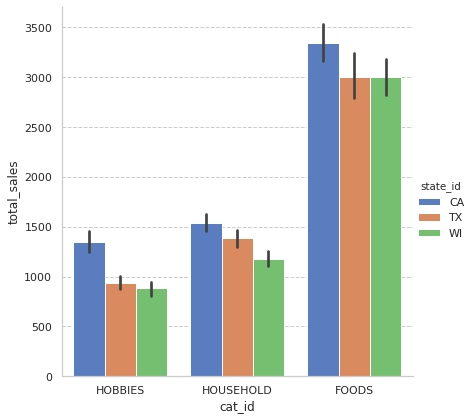

In [26]:
stv['total_sales'] = stv[day_cols].sum(axis=1)
sns.catplot(x='cat_id', 
            y='total_sales', 
            hue='state_id', 
            data=stv, kind='bar', height=6, aspect=1)
# for x, y in zip(stv['cat_id'], stv['total_sales']):
    

In [27]:
display(stv['cat_id'].unique())
display(stv['state_id'].unique())
display(stv['dept_id'].unique())

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

array(['CA', 'TX', 'WI'], dtype=object)

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [28]:
stv.loc[stv['id']=='FOODS_3_090_CA_3_validation'][day_cols]

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  \
8412  108  132  102  120  106  123  279  175  186   120     0     0     0   

      d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  \
8412     0     0     0     0     0     0     0     0     0     0     0     0   

      d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  d_106  d_107  \
8412     0     0      0      0      0      0      0      0      0      0   

      d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  d_116  d_117  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  d_126  d_127  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  d_136  d_137  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_138  d_139  d_140  d_141  d_142  d_143  d_144  d_145  d_146  d_147  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_148  d_149  d_150  d_151  d_152  d_153  d_154  d_155  d_156  d_157  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_158  d_159  d_160  d_161  d_162  d_163  d_164  d_165  d_166  d_167  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_168  d_169  d_170  d_171  d_172  d_173  d_174  d_175  d_176  d_177  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_178  d_179  d_180  d_181  d_182  d_183  d_184  d_185  d_186  d_187  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_188  d_189  d_190  d_191  d_192  d_193  d_194  d_195  d_196  d_197  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_198  d_199  d_200  d_201  d_202  d_203  d_204  d_205  d_206  d_207  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_208  d_209  d_210  d_211  d_212  d_213  d_214  d_215  d_216  d_217  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_218  d_219  d_220  d_221  d_222  d_223  d_224  d_225  d_226  d_227  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_228  d_229  d_230  d_231  d_232  d_233  d_234  d_235  d_236  d_237  \
8412      0      0      0      0      0      0      0      0      0      0   

      d_238  d_239  d_240  d_241  d_242  d_243  d_244  d_245  d_246  d_247  \
8412      0      0    420    280    273    254    240    336    478    359   

      d_248  d_249  d_250  d_251  d_252  d_253  d_254  d_255  d_256  d_257  \
8412    234    180    170    249    254    460    170    229    225    152   

      d_258  d_259  d_260  d_261  d_262  d_263  d_264  d_265  d_266  d_267  \
8412    248    245    303    336    206    266    219    249    267    371   

      d_268  d_269  d_270  d_271  d_272  d_273  d_274  d_27

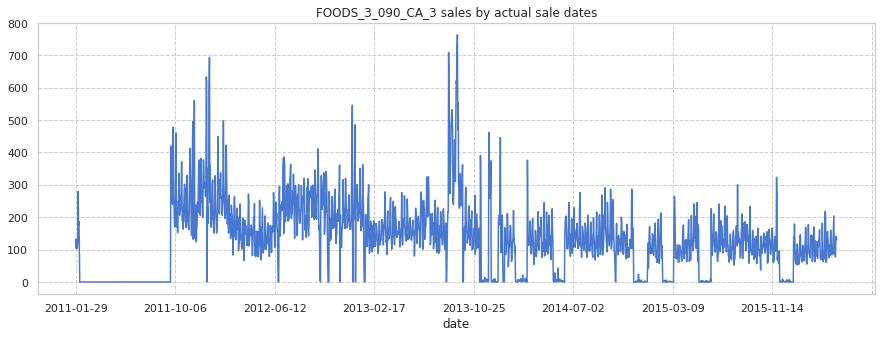

In [29]:
# FOODS_3_090_CA_3_validation
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][day_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'].plot(figsize=(15, 5), 
                                                   title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [30]:
# Select more top selling examples

# HOBBIES_1_234_CA_3_validation
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')

# HOUSEHOLD_1_118_CA_3_validation
example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')

### Sales broken down by time variables

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


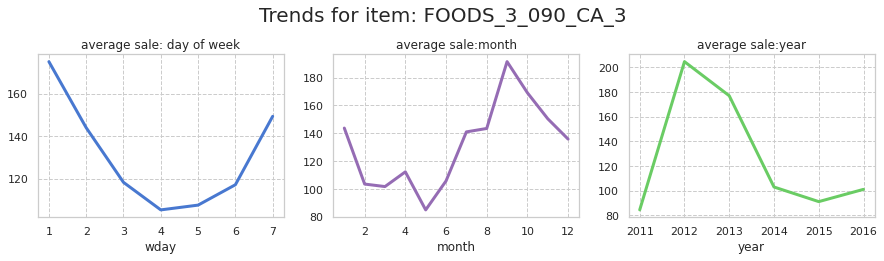

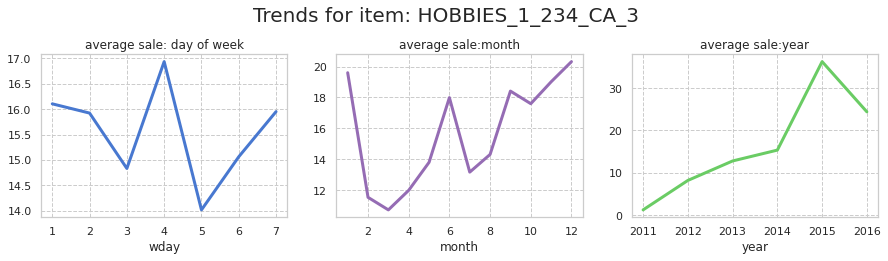

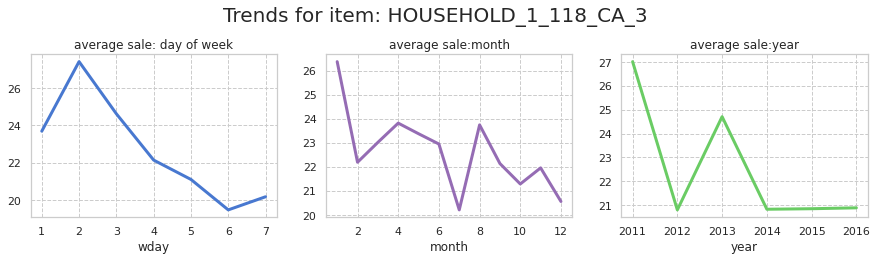

In [31]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]

for idx, df in enumerate(example_df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    df.groupby('wday').mean()[examples[idx]].plot(kind='line', 
                                                  title='average sale: day of week', 
                                                  lw=3, 
                                                  color=color_pal[0], 
                                                  ax=ax1)
    df.groupby('month').mean()[examples[idx]].plot(kind='line',
                                                   title='average sale:month',
                                                   lw=3,
                                                   color=color_pal[4],
                                                   ax=ax2)
    df.groupby('year').mean()[examples[idx]].plot(kind='line', 
                                                  title='average sale:year', 
                                                  lw=3, 
                                                  color=color_pal[2], 
                                                  ax=ax3)
    fig.suptitle(f'Trends for item: {examples[idx]}', 
                 size=20, 
                 y=1.1)
plt.show()

### Lets look at a lot of different items

In [32]:
stv_samples = stv.sample(20, random_state=529).set_index('id')[d_cols].T
twenty_samples = stv_samples.merge(cal.set_index('d')['date'],
                                   left_index=True,
                                   right_index=True,
                                   validate='1:1').set_index('date')
twenty_samples.head()

FOODS_1_013_TX_1_validation  HOUSEHOLD_1_311_WI_1_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_3_805_CA_3_validation  HOUSEHOLD_2_369_TX_2_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                1   
2011-01-31                            0                                3   
2011-02-01                            0                                0   
2011-02-02                            0                                1   

            HOUSEHOLD_1_080_TX_2_validation  HOUSEHOLD_1_463_CA_2_validation  \
date                                                                           
2011-01-29                                0                                0   
2011-01-30                                0                                0   
2011-01-31                                0                                0   
2011-02-01                                0                                0   
2011-02-02                                0                                0   

            FOODS_2_046_CA_1_validation  HOUSEHOLD_2_102_WI_3_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_2_131_TX_2_validation  HOUSEHOLD_2_115_WI_1_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                1   
2011-02-02                            0                                0   

            HOUSEHOLD_1_192_CA_3_validation  FOODS_3_641_CA_1_validation  \
date                                                                       
2011-01-29                                0                            0   
2011-01-30                                0                            0   
2011-01-31                                2                            0   
2011-02-01                                0                            0   
2011-02-02                                1                            0   

            FOODS_2_110_WI_2_validation  HOUSEHOLD_2_060_TX_2_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_3_018_CA_3_validation  FOODS_1_137_WI_2_validation  \
date                                                                   
2011-01-29                            0                            6   
2011-01-30                           

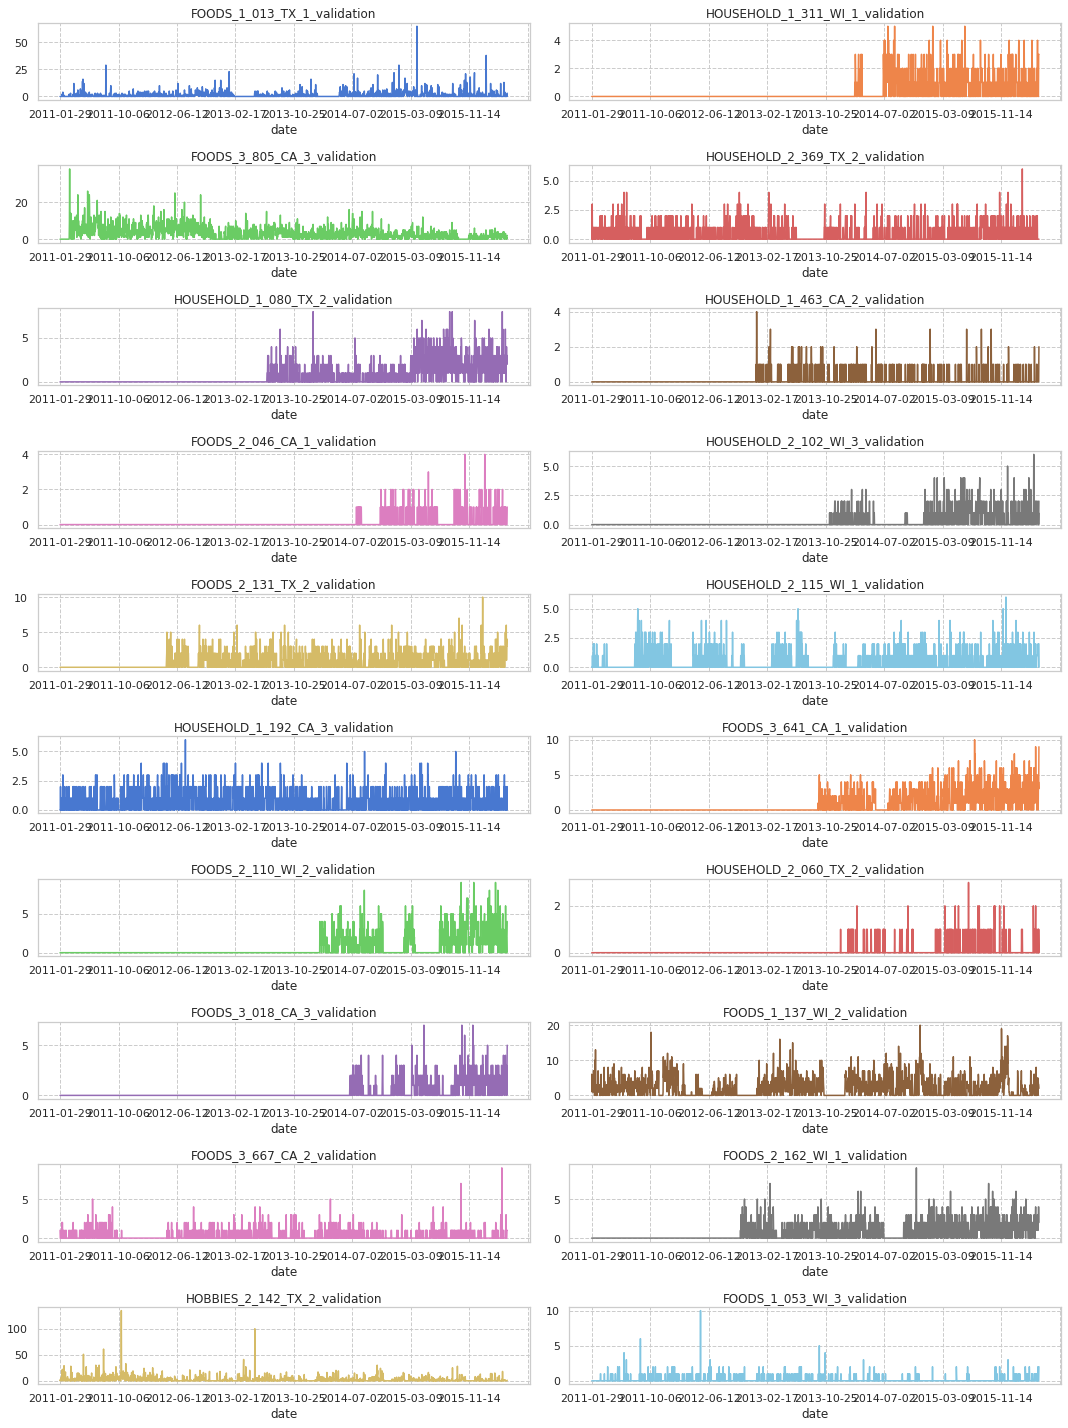

In [33]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0

for item in twenty_samples.columns:
    twenty_samples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

### Combined Sales over Time by Type

In [34]:
stv.groupby('cat_id').count()['id'].sort_values()

cat_id
HOBBIES       5650
HOUSEHOLD    10470
FOODS        14370
Name: id, dtype: int64

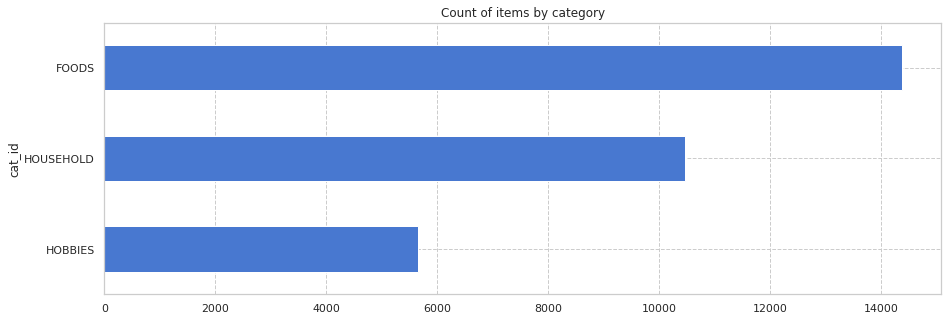

In [35]:
stv.groupby('cat_id').count()['id'].sort_values().plot(kind='barh',
                                                       figsize=(15, 5),
                                                       title='Count of items by category')
plt.show()

In [134]:
stv_samples

id      FOODS_1_013_TX_1_validation  HOUSEHOLD_1_311_WI_1_validation  \
d_1                               0                                0   
d_2                               0                                0   
d_3                               0                                0   
d_4                               0                                0   
d_5                               0                                0   
...                             ...                              ...   
d_1909                            0                                1   
d_1910                            2                                0   
d_1911                            1                                0   
d_1912                            0                                3   
d_1913                            3                                3   

id      FOODS_3_805_CA_3_validation  HOUSEHOLD_2_369_TX_2_validation  \
d_1                               0                                0   
d_2                               0                                1   
d_3                               0                                3   
d_4                               0                                0   
d_5                               0                                1   
...                             ...                              ...   
d_1909                            0                                0   
d_1910                            1                                0   
d_1911                            0                                0   
d_1912                            2                                0   
d_1913                            2                                0   

id      HOUSEHOLD_1_080_TX_2_validation  HOUSEHOLD_1_463_CA_2_validation  \
d_1                                   0                                0   
d_2                                   0                                0   
d_3                                   0                                0   
d_4                                   0                                0   
d_5                                   0                                0   
...                                 ...                              ...   
d_1909                                3                                0   
d_1910                                4                                0   
d_1911                                3                                0   
d_1912                                2                                0   
d_1913                                3                                2   

id      FOODS_2_046_CA_1_validation  HOUSEHOLD_2_102_WI_3_validation  \
d_1                               0                                0   
d_2                               0                                0   
d_3                               0                                0   
d_4                               0                                0   
d_5                               0                                0   
...                             ...                              ...   
d_1909                            0                                1   
d_1910                            0                                0   
d_1911                            0                                1   
d_1912                            0                                0   
d_1913                            1                                2   

id      FOODS_2_131_TX_2_validation  HOUSEHOLD_2_115_WI_1_validation  \
d_1                               0                                0   
d_2                               0                                0   
d_3                               0                                0   
d_4                               0                                1   
d_5                               0                                0   
...                             ...                         

In [135]:
twenty_samples

FOODS_1_013_TX_1_validation  HOUSEHOLD_1_311_WI_1_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   
...                                 ...                              ...   
2016-04-20                            0                                1   
2016-04-21                            2                                0   
2016-04-22                            1                                0   
2016-04-23                            0                                3   
2016-04-24                            3                                3   

            FOODS_3_805_CA_3_validation  HOUSEHOLD_2_369_TX_2_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                1   
2011-01-31                            0                                3   
2011-02-01                            0                                0   
2011-02-02                            0                                1   
...                                 ...                              ...   
2016-04-20                            0                                0   
2016-04-21                            1                                0   
2016-04-22                            0                                0   
2016-04-23                            2                                0   
2016-04-24                            2                                0   

            HOUSEHOLD_1_080_TX_2_validation  HOUSEHOLD_1_463_CA_2_validation  \
date                                                                           
2011-01-29                                0                                0   
2011-01-30                                0                                0   
2011-01-31                                0                                0   
2011-02-01                                0                                0   
2011-02-02                                0                                0   
...                                     ...                              ...   
2016-04-20                                3                                0   
2016-04-21                                4                                0   
2016-04-22                                3                                0   
2016-04-23                                2                                0   
2016-04-24                                3                                2   

            FOODS_2_046_CA_1_validation  HOUSEHOLD_2_102_WI_3_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   
...                                 ...                              ...   
2016-04-20                            0                                1   
2016-04-21                            0                                0   
2016-04-22                            0                                1   
2016-04-23                            0                                0   
2016-04-24                            1                                2   

    

FOODS_1_013_TX_1_validation  HOUSEHOLD_1_311_WI_1_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_3_805_CA_3_validation  HOUSEHOLD_2_369_TX_2_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                1   
2011-01-31                            0                                3   
2011-02-01                            0                                0   
2011-02-02                            0                                1   

            HOUSEHOLD_1_080_TX_2_validation  HOUSEHOLD_1_463_CA_2_validation  \
date                                                                           
2011-01-29                                0                                0   
2011-01-30                                0                                0   
2011-01-31                                0                                0   
2011-02-01                                0                                0   
2011-02-02                                0                                0   

            FOODS_2_046_CA_1_validation  HOUSEHOLD_2_102_WI_3_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_2_131_TX_2_validation  HOUSEHOLD_2_115_WI_1_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                1   
2011-02-02                            0                                0   

            HOUSEHOLD_1_192_CA_3_validation  FOODS_3_641_CA_1_validation  \
date                                                                       
2011-01-29                                0                            0   
2011-01-30                                0                            0   
2011-01-31                                2                            0   
2011-02-01                                0                            0   
2011-02-02                                1                            0   

            FOODS_2_110_WI_2_validation  HOUSEHOLD_2_060_TX_2_validation  \
date                                                                       
2011-01-29                            0                                0   
2011-01-30                            0                                0   
2011-01-31                            0                                0   
2011-02-01                            0                                0   
2011-02-02                            0                                0   

            FOODS_3_018_CA_3_validation  FOODS_1_137_WI_2_validation  \
date                                                                   
2011-01-29                            0                            6   
2011-01-30                           

### 過去売り上げのテーブルをindex:日付、columns:商品店舗IDにしたものをpast_tableと命名

In [36]:
past_sales = stv.set_index('id')[d_cols].T.merge(cal.set_index('d')['date'],
                                                 left_index=True,
                                                 right_index=True,
                                                 validate='1:1').set_index('date')
past_sales.head()

HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_007_CA_1_validation  HOBBIES_1_008_CA_1_validation  \
date                                                                       
2011-01-29                              0                             12   
2011-01-30                              0                             15   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_009_CA_1_validation  HOBBIES_1_010_CA_1_validation  \
date                                                                       
2011-01-29                              2                              0   
2011-01-30                              0                              0   
2011-01-31                              7                              1   
2011-02-01                              3                              0   
2011-02-02                              0                              0   

            HOBBIES_1_011_CA_1_validation  HOBBIES_1_012_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              2   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_013_CA_1_validation  HOBBIES_1_014_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_015_CA_1_validation  HOBBIES_1_016_CA_1_validation  \
date                                                                       
2011-01-29                              4                              5   
2011-01-30                              0            

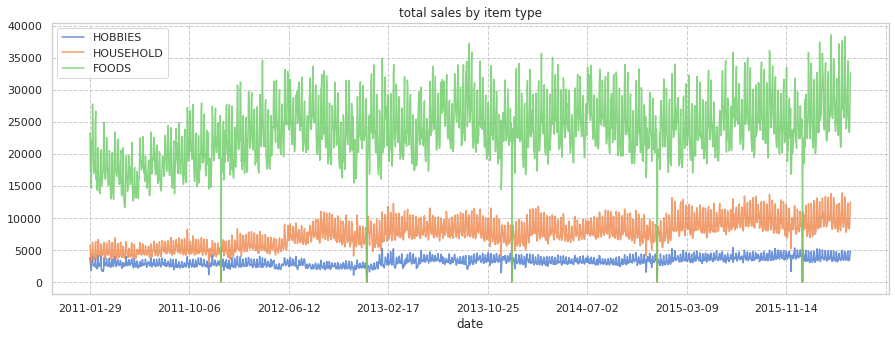

In [37]:
for cate in stv['cat_id'].unique():
    cate_items_col = [c for c in past_sales.columns if cate in c]
    past_sales[cate_items_col].sum(axis=1).plot(figsize=(15, 5),
                                                alpha=0.8,
                                                title='total sales by item type')
plt.legend(stv['cat_id'].unique())
plt.show()

### Sales by Store

In [38]:
sp['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

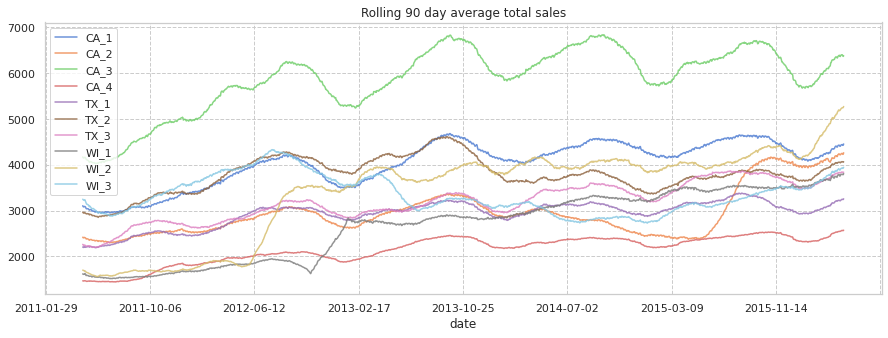

In [39]:
#rollling 90 day
store_list = sp['store_id'].unique()
for store in store_list:
    store_items = [col for col in past_sales.columns if store in col]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(15, 5),
                                                         alpha=0.8,
                                                         title='Rolling 90 day average total sales')
plt.legend(store_list)
plt.show()

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


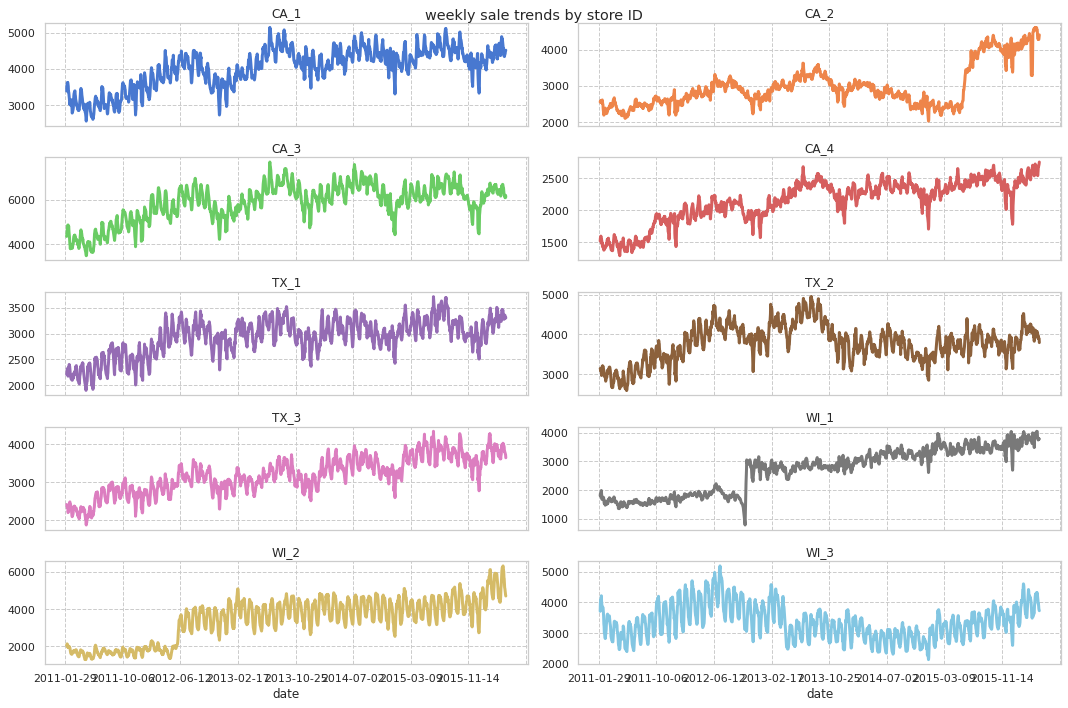

In [40]:
#rollling 7 day

fig, axs = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axs.flatten()
ax_idx = 0

for store in store_list:
    store_items = [col for col in past_sales.columns if store in col]
    past_sales[store_items].sum(axis=1).rolling(7).mean().plot(alpha=1,
                                                               ax=axes[ax_idx],
                                                               title=store,
                                                               lw=3,
                                                               color=next(color_cycle))
    ax_idx += 1
plt.suptitle('weekly sale trends by store ID')
plt.tight_layout()
plt.show()

### sales heatmap calendar
high and low

In [41]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The highest sale date was:', past_sales.sum(axis=1).sort_values().index[-1],
     'with', past_sales.sum(axis=1).sort_values().values[-1], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The highest sale date was: 2016-03-06 with 57218 sales


In [42]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty Diminised'] not found. Falling back to DejaVu Sans.


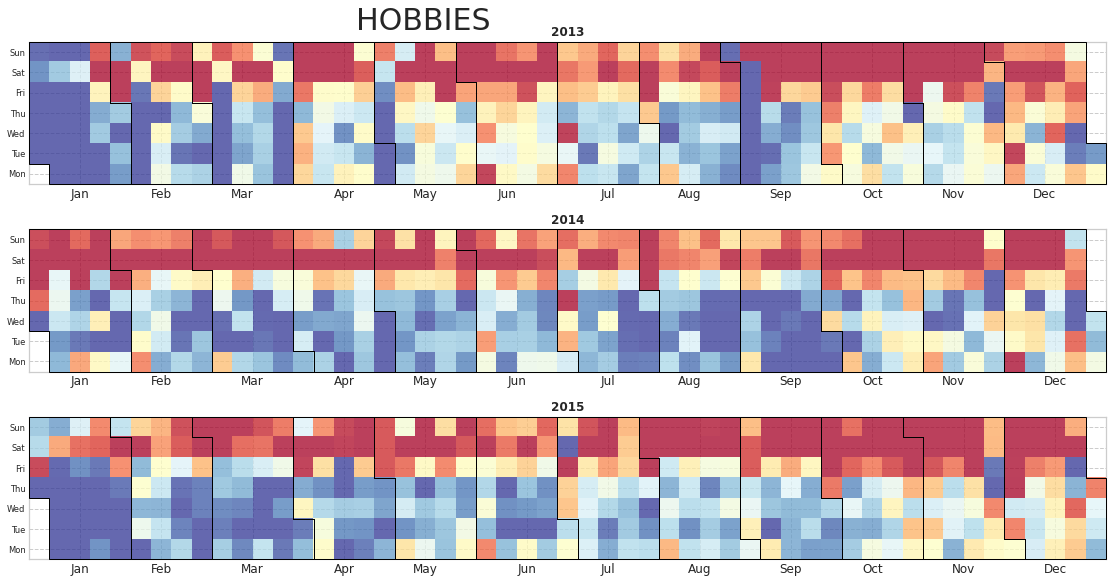

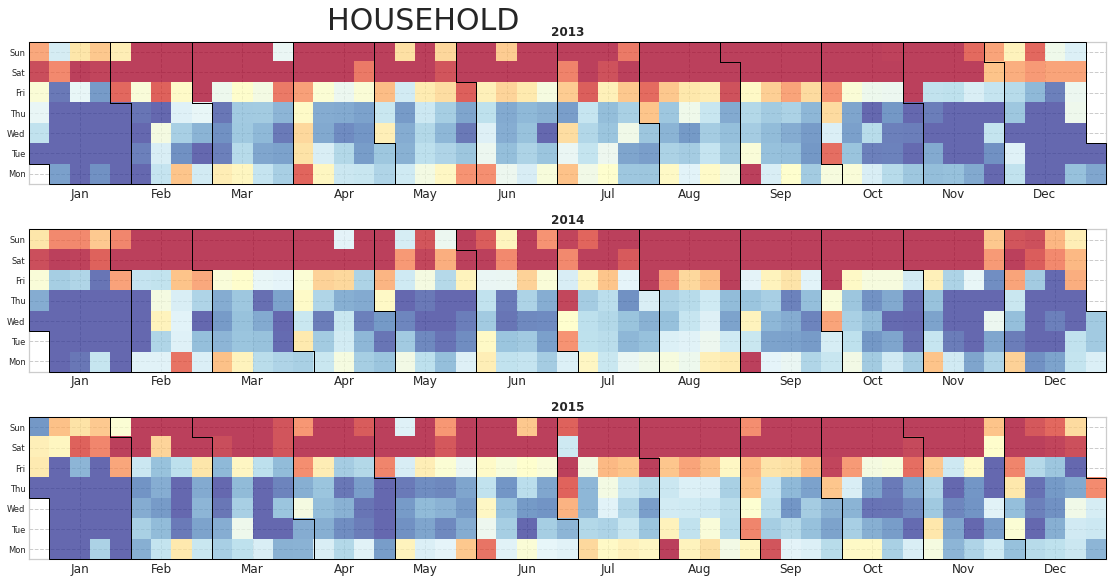

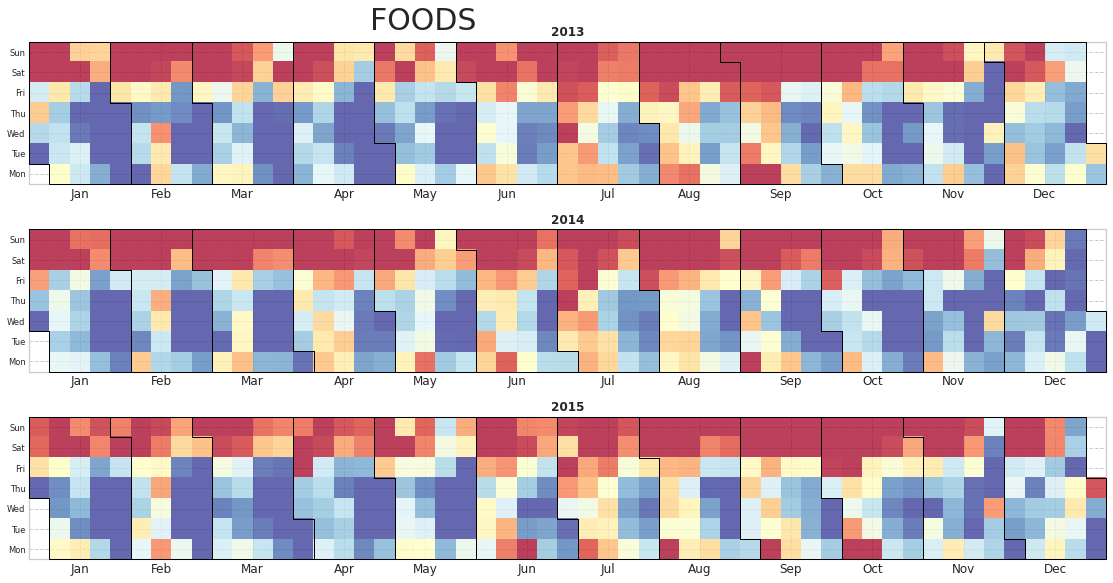

In [43]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

### Sale Prices

FOODS_3_090

In [47]:
sp[sp['item_id']=='FOODS_3_090']

store_id      item_id  wm_yr_wk  sell_price category
530695      CA_1  FOODS_3_090     11101     1.25000    FOODS
530696      CA_1  FOODS_3_090     11102     1.25000    FOODS
530697      CA_1  FOODS_3_090     11103     1.25000    FOODS
530698      CA_1  FOODS_3_090     11104     1.25000    FOODS
530699      CA_1  FOODS_3_090     11105     1.25000    FOODS
...          ...          ...       ...         ...      ...
6675242     WI_3  FOODS_3_090     11617     1.44043    FOODS
6675243     WI_3  FOODS_3_090     11618     1.44043    FOODS
6675244     WI_3  FOODS_3_090     11619     1.44043    FOODS
6675245     WI_3  FOODS_3_090     11620     1.44043    FOODS
6675246     WI_3  FOODS_3_090     11621     1.44043    FOODS

[2820 rows x 5 columns]

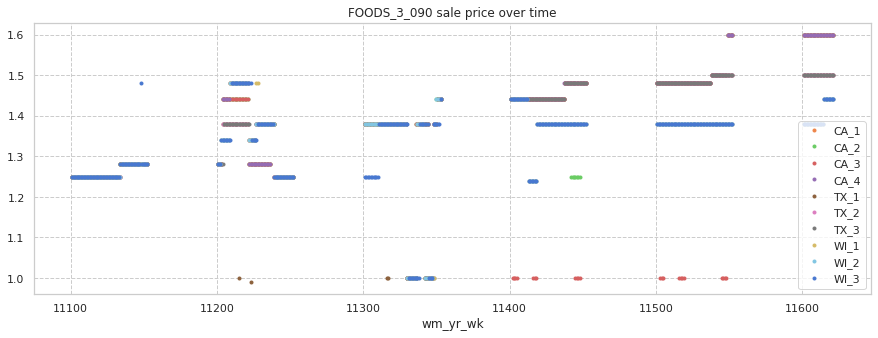

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store_id, df in sp[sp['item_id']=='FOODS_3_090'].groupby('store_id'):
    df.plot(x='wm_yr_wk',
            y='sell_price',
            style='.',
            color=next(color_cycle),
            figsize=(15, 5),
            title='FOODS_3_090 sale price over time',
            ax=ax,
            legend=store_id)
    stores.append(store_id)
    plt.legend()
plt.legend(stores)
plt.show()

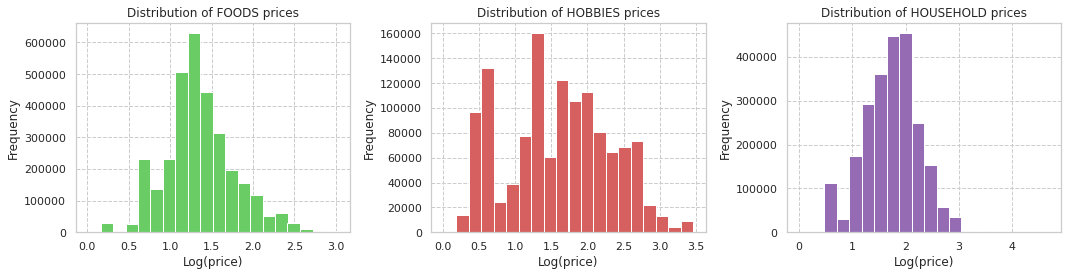

In [51]:
sp['category'] = sp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for category, df in sp.groupby('category'):
    ax = df['sell_price'].apply(np.log1p).plot(kind='hist',
                                               bins=20,
                                               title=f'Distribution of {category} prices',
                                               ax=axs[i],
                                               color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()